## Derivation of 10-state EKF

From AHRS (https://ahrs.readthedocs.io/en/latest/filters/ekf.html)

#### Prediction
We use a 10-state vector, $s$
$$\mathbf{s}_{t}=\begin{bmatrix}\mathbf{x}_{t} \\ \mathbf{v}_{t} \\ \mathbf{q}_{t} \end{bmatrix}$$

Quaternion Dynamics:
$$\begin{split}\begin{array}{rcl}
\hat{\mathbf{q}}_t &=& \mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t) \\
&=&\Big(\mathbf{I}_4 + \frac{\Delta t}{2}\boldsymbol\Omega_t\Big)\mathbf{q}_{t-1} \\
\begin{bmatrix}\hat{q_w} \\ \hat{q_x} \\ \hat{q_y} \\ \hat{q_z}\end{bmatrix}
&=&
\begin{bmatrix}
    q_w - \frac{\Delta t}{2} \omega_x q_x - \frac{\Delta t}{2} \omega_y q_y - \frac{\Delta t}{2} \omega_z q_z\\
    q_x + \frac{\Delta t}{2} \omega_x q_w - \frac{\Delta t}{2} \omega_y q_z + \frac{\Delta t}{2} \omega_z q_y\\
    q_y + \frac{\Delta t}{2} \omega_x q_z + \frac{\Delta t}{2} \omega_y q_w - \frac{\Delta t}{2} \omega_z q_x\\
    q_z - \frac{\Delta t}{2} \omega_x q_y + \frac{\Delta t}{2} \omega_y q_x + \frac{\Delta t}{2} \omega_z q_w
\end{bmatrix}
\end{array}\end{split}$$
$$\mathbf{\Omega_{t}}=\begin{bmatrix}0 & -\mathbf{\omega} \\ \mathbf{\omega} & -\lfloor\omega\rfloor_{\times} \end{bmatrix}$$

Position and Velocity State Dynamics:
$$\hat{\mathbf{x}}_{t}=\mathbf{x}_{t-1} + \mathbf{v}_{t-1}\Delta{t} $$
$$\hat{\mathbf{v}}_{t}=\mathbf{v}_{t-1} + ({}^{I}\mathbf{R}_{B}{}^{B}\textbf{a}_{t-1}+\textbf{g})\Delta{t}$$

Quaternion State Jacobian:
$$\begin{split}\begin{array}{rcl}
\mathbf{F}(\mathbf{s}_{t-1}, \boldsymbol\omega_t, \mathbf{a}_{t})
&=& \frac{\partial\mathbf{f}(\mathbf{s}_{t-1}, \boldsymbol\omega_t, \mathbf{a}_{t})}{\partial\mathbf{s}}
\end{array}\end{split}
$$

Pos & Vel State Jacobian:
TODO

Process Noise Covariance:
$$\hat{\mathbf{P}}_t = \mathbf{F}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)\mathbf{P}_{t-1}\mathbf{F}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)^T + \mathbf{Q}_t$$
$$\begin{split}\begin{array}{rcl}
\mathbf{W}_t &=& \frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\boldsymbol\omega} \\
&=& \begin{bmatrix}
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\omega_x} &
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\omega_y} &
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\omega_z}
\end{bmatrix} \\
&=& \frac{\Delta t}{2}
\begin{bmatrix}
-q_x & -q_y & -q_z \\
q_w & -q_z & q_y \\
q_z & q_w & -q_x \\
-q_y & q_x & q_w
\end{bmatrix}
\end{array}\end{split}$$

$$\mathbf{Q}_t = \sigma_\boldsymbol\omega^2\mathbf{W}_t\mathbf{W}_t^T$$

Position and Velocity State Noise
$$\mathbf{Q}_x = \sigma_{a}\Delta{t}^{4}\mathbf{I}_{\text{3x3}}$$
$$\mathbf{Q}_v = \sigma_{a}\Delta{t}^{2}\mathbf{I}_{\text{3x3}}$$



#### Correction
Measurement Matrix:
$$\mathbf{q}_t = \hat{\mathbf{q}}_t + \mathbf{K}_t \big(\mathbf{z}_t - \mathbf{h}(\mathbf{q}_t)\big)$$
$$\begin{split}\mathbf{z}_t =
\begin{bmatrix}\mathbf{a}_t \\ \mathbf{m}_t \\ \textbf{pos}_{\text{gps}} \\ \textbf{vel}_{\text{gps}}\end{bmatrix}\end{split}$$

H Matrix:
$$\begin{split}\begin{array}{rcl}
\mathbf{h}(\hat{\mathbf{q}}_t) &=& \begin{bmatrix}\hat{\mathbf{a}} \\ \hat{\mathbf{m}}\end{bmatrix}
= \begin{bmatrix}\mathbf{C}(\hat{\mathbf{q}})^T \mathbf{g} \\ \mathbf{C}(\hat{\mathbf{q}})^T \mathbf{r}\end{bmatrix}
\end{array}\end{split}$$

TODO Add the additional two H states (position and velocity from accelerometer integration) and then add H Jacobian

$\textbf{g}$ is the gravitational reference and $\textbf{r}$ is the magnetic field reference including inclination and declination.

In [5]:
import struct
import math
import time
import csv

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation as R
from ahrs.common.orientation import acc2q
from ahrs import Quaternion

from scipy.signal import butter, filtfilt, lfilter, lfilter_zi

In [6]:
## Parse configs
#max_iter = 125
max_iter = None

def parse(frame, ctx):
    #print(f"pkt found {len(frame)} {frame[2]}")
    if frame[2]==0x01:
        roll, pitch, yaw = struct.unpack('<fff', frame[4:])
        ctx['roll'].append(roll)
        ctx['pitch'].append(pitch)
        ctx['yaw'].append(yaw)

    elif frame[2]==0x02:
        pos_x, pos_y, pos_z = struct.unpack('<fff', frame[4:])
        ctx['pos_x'].append(pos_x)
        ctx['pos_y'].append(pos_y)
        ctx['pos_z'].append(pos_z)

    elif frame[2]==0x03:
        vel_x, vel_y, vel_z = struct.unpack('<fff', frame[4:])
        ctx['vel_x'].append(vel_x)
        ctx['vel_y'].append(vel_y)
        ctx['vel_z'].append(vel_z)

    elif frame[2]==0x04:
        er_x, er_y, er_z = struct.unpack('<fff', frame[4:])
        ctx['er_x'].append(er_x)
        ctx['er_y'].append(er_y)
        ctx['er_z'].append(er_z)

    elif frame[2]==0x05:
        force, rt, pt, yt = struct.unpack('<ffff', frame[4:])
        ctx['force'].append(force)
        ctx['rt'].append(rt)
        ctx['pt'].append(pt)
        ctx['yt'].append(yt)

    elif frame[2]==0x06:
        m0, m1, m2, m3 = struct.unpack('<hhhh', frame[4:])
        ctx['m0'].append(m0)
        ctx['m1'].append(m1)
        ctx['m2'].append(m2)
        ctx['m3'].append(m3)

    elif frame[2]==0x07:
        accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, comp_x, comp_y, comp_z = struct.unpack('<fffffffff', frame[4:])
        ctx['accel_x'].append(accel_x)
        ctx['accel_y'].append(accel_y)
        ctx['accel_z'].append(accel_z)
        ctx['gyro_x'].append(gyro_x)
        ctx['gyro_y'].append(gyro_y)
        ctx['gyro_z'].append(gyro_z)
        ctx['comp_x'].append(comp_x)
        ctx['comp_y'].append(comp_y)
        ctx['comp_z'].append(comp_z)

    elif frame[2]==0x08:
        pos_x_a, pos_y_a, pos_z_a, vel_x_a, vel_y_a, vel_z_a, eul_x_a, eul_y_a, eul_z_a, er_x_a, er_y_a, er_z_a = struct.unpack('<ffffffffffff',frame[4:])
        ctx['pos_x_a'].append(pos_x_a)
        ctx['pos_y_a'].append(pos_y_a)
        ctx['pos_z_a'].append(pos_z_a)
        ctx['vel_x_a'].append(vel_x_a)
        ctx['vel_y_a'].append(vel_y_a)
        ctx['vel_z_a'].append(vel_z_a)
        ctx['eul_x_a'].append(eul_x_a)
        ctx['eul_y_a'].append(eul_y_a)
        ctx['eul_z_a'].append(eul_z_a)        
        ctx['er_x_a'].append(er_x_a)        
        ctx['er_y_a'].append(er_y_a)        
        ctx['er_z_a'].append(er_z_a)
    
    elif frame[2]==0x09:
        lat, lng, alt_cm, veln, vele, veld = struct.unpack('<iiifff', frame[4:])
        ctx['gps_lat'].append(lat)
        ctx['gps_lng'].append(lng)
        ctx['gps_alt_cm'].append(alt_cm)
        ctx['gps_vel_north'].append(veln)
        ctx['gps_vel_east'].append(vele)
        ctx['gps_vel_down'].append(veld)


with open('../../../build-generic/mincopter_log.txt','rb') as rfile:
    x = rfile.read()

ctx = {
    'roll': [],
    'pitch': [],
    'yaw': [],
    'er_x': [],
    'er_y': [],
    'er_z': [],
    'pos_x': [],
    'pos_y': [],
    'pos_z': [],
    'vel_x': [],
    'vel_y': [],
    'vel_z': [],
    'force': [],
    'rt': [],
    'pt': [],
    'yt': [],
    'm0': [],
    'm1': [],
    'm2': [],
    'm3': [],
    'accel_x': [],
    'accel_y': [],
    'accel_z': [],
    'gyro_x': [],
    'gyro_y': [],
    'gyro_z': [],
    'comp_x': [],
    'comp_y': [],
    'comp_z': [],
    'pos_x_a': [],
    'pos_y_a': [],
    'pos_z_a': [],
    'vel_x_a': [],
    'vel_y_a': [],
    'vel_z_a': [],
    'eul_x_a': [],
    'eul_y_a': [],
    'eul_z_a': [],
    'er_x_a': [],
    'er_y_a': [],
    'er_z_a': [],
    'gps_lat': [],
    'gps_lng': [],
    'gps_alt_cm': [],
    'gps_vel_north': [],
    'gps_vel_east': [],
    'gps_vel_down': []
}
    
idx = 0
while(idx<len(x)):
    frame_type = x[idx+2]
    frame_len = x[idx+3]
    frame = x[idx:idx+frame_len+4]
    parse(frame, ctx)
    idx += len(frame)

## Correct a few bad accel readings
for i in range(0,20):
    ctx['accel_x'][i] = 0
    ctx['accel_y'][i] = 0
    ctx['accel_z'][i] = 0
    

In [7]:
import numpy as np
import casadi as ca
import math
from scipy.spatial.transform import Rotation as R

''' Extended Kalman Filter w 10-state (3-pos, 3-vel, att quaternion) but no sensor bias states'''

def skew(v):
    '''Returns a skew-symmetric of a matrix'''
    return ca.vertcat(
        ca.horzcat(0, -v[2], v[1]),
        ca.horzcat(v[2], 0, -v[0]),
        ca.horzcat(-v[1], v[0], 0))

def to_rotation(q):
    return ca.vertcat(
        ca.horzcat(
            q[0]**2+q[1]**2-q[2]**2-q[3]**2,
            2*(q[1]*q[2]-q[0]*q[3]),
            2*(q[1]*q[3]+q[0]*q[2])),
        ca.horzcat(
            2*(q[1]*q[2]+q[0]*q[3]),
            q[0]*q[0]-q[1]*q[1]+q[2]*q[2]-q[3]*q[3],
            2*(q[2]*q[3]-q[0]*q[1])),
        ca.horzcat(
            2*(q[1]*q[3]-q[0]*q[2]),
            2*(q[0]*q[1]+q[2]*q[3]),
            q[0]*q[0]-q[1]*q[1]-q[2]*q[2]+q[3]*q[3]))

def setup_ins_ekf():
    ''' The returned EKF requires parameters in the following format/units.

    q (4,1) - initial quaternion state estimate
    a_reading (3,1) - normalized accelerometer reading in ENU frame (stationary g vector would be [0 0 g])
    m_reading (3,1) - normalized magnetometer reading in ENU frame
    g_reading (3,1) - gyrometer reading in rad/s
    dt (1,1) - time elapsed since last reading/update
    gyro_var - gyrometer variance estimate
    accel_var - accelerometer variance estimate
    mag_var - magnetometer variance estimate

    '''

    ########################################
    ### 1. Prediction
    ########################################

    ## Symbolic variables - predict

    # Gyrometer reading and variance
    w = ca.SX.sym('w', 3, 1)
    gyro_var = ca.SX.sym('gvar')

    # Accelerometer reading
    a_reading = ca.SX.sym('a', 3, 1)
    accel_var = ca.SX.sym('avar')

    # Timestep
    dt = ca.SX.sym('dt')

    # Initial quaternion
    q = ca.SX.sym('q', 4, 1)
    p = ca.SX.sym('p', 10, 10)

    ## Position and velocity states
    x = ca.SX.sym('x', 3, 1)
    v = ca.SX.sym('v', 3, 1)

    # Calculate omega vec for attitude quaternion
    omega = ca.vertcat(
        ca.horzcat(0, -w.T),
        ca.horzcat(w, -skew(w)))

    # Calculate rotation matrix
    C_rot = to_rotation(q)

    # Calculate gravitational reference vector
    g_ref = ca.vertcat(0,0,-1)

    # State prediction using gyro and accelerometer readings
    state_f = ca.vertcat(
            x + v*dt,
            v + (C_rot.T @ a_reading - g_ref)*dt,
            (ca.SX_eye(4)+(dt/2)*omega) @ q
            )
    
    # 10-state matrix
    state_vec = ca.vertcat(x,v,q)

    ## Compute state jacobian
    state_jac = ca.jacobian(state_f, state_vec)
    if False:
        print(state_jac)

    ## State noise matrix
    xi_k = ca.vertcat(
            -(q[1:4]).T,
            q[0]*ca.SX_eye(3) + skew(q[1:4])
            )

    gy_noise = (-dt/2)*(xi_k @ ca.vertcat(ca.sqrt(gyro_var), ca.sqrt(gyro_var), ca.sqrt(gyro_var)) )
    noise_q = gyro_var*(gy_noise @ gy_noise.T)
    process_noise = ca.vertcat(
            ca.horzcat(accel_var*(dt**4)*ca.SX_eye(3), ca.SX.zeros(3,3), ca.SX.zeros(3,4)),
            ca.horzcat(ca.SX.zeros(3,3), accel_var*(dt**2)*ca.SX_eye(3), ca.SX.zeros(3,4)),
            ca.horzcat(ca.SX.zeros(4,3), ca.SX.zeros(4,3), noise_q)
            )

    # Estimation process covariance
    p_est = state_jac @ p @ state_jac.T + process_noise

    ''' Predict function

    Arguments:
        - dt : timestep in seconds since last predict call
        - w : gyrometer reading
        - a_reading : accelerometer reading
        - gyro_var : gyrometer noise
        - accel_var : accelerometer noise
        - p : covariance matrix
        - q : attitude quaternion (state)
        - x : position (state)
        - v : velocity (state)

    Returns:
        - state_f : Estimate of state
        - p_est   : Estimate of covariance matrix
    '''
    ekf_predict = ca.Function('ekf_predict', [dt, w, a_reading, gyro_var, accel_var, p, q, x, v], [state_f, p_est])

    ########################################
    ## 2. Correction
    ########################################

    ## Symbolic variables for correction step

    # Predicted state vector (output from predict step, (x,v,q) )
    state_est = ca.SX.sym('state_estimate', 10, 1)
    
    # Predicted covariance vector (output from predict step)
    cov_est = ca.SX.sym('covariance_estimate', 10, 10)

    # Magnetometer reading and variance
    m_reading = ca.SX.sym('m', 3, 1)
    mag_var = ca.SX.sym('mvar')

    # GPS Position reading and variance
    gps_pos = ca.SX.sym('gps_x', 3, 1)
    gps_pos_var = ca.SX.sym('gps_xvar')

    # GPS Velocity reading and variance
    gps_vel = ca.SX.sym('gps_v', 3, 1)
    gps_vel_var = ca.SX.sym('gps_vvar')

    ### Magnetic field reference vector

    # Our magnetic field is in ENU frame. 
    # We use 68deg as our magnetic field inclination and 12deg as declination
    _m0 = np.cos(12*np.pi/180)*np.cos(68*np.pi/180)
    _m1 = np.sin(12*np.pi/180)*np.cos(68*np.pi/180)
    _m2 = -np.sin(68*np.pi/180)
    _norm = np.linalg.norm([_m0, _m1, _m2])
    m_ref = ca.vertcat(_m0, _m1, _m2) / _norm

    # Compute rotation again
    est_C_rot = to_rotation(state_est[6:10])

    ### Measurement matrix (estimated reference vectors in sensor frame)
    measurement = ca.vertcat(est_C_rot.T @ g_ref,
                             est_C_rot.T @ m_ref,
                             state_est[0:3], # position
                             state_est[3:6]) # velocity

    ## Measurement jacobian (wrt state)
    measurement_jacobian = ca.jacobian(measurement, state_est)

    ## Measurement noise
    m_noise = ca.vertcat(
        ca.horzcat(accel_var*ca.SX_eye(3), ca.SX.zeros(3,9)),
        ca.horzcat(ca.SX.zeros(3,3), mag_var*ca.SX_eye(3), ca.SX.zeros(3,6)),
        ca.horzcat(ca.SX.zeros(3,6), gps_pos_var*ca.SX_eye(3), ca.SX.zeros(3,3)),
        ca.horzcat(ca.SX.zeros(3,9), gps_vel_var*ca.SX_eye(3))
        )

    ### Error between reference vector estimates (in sensor frame) and actual sensor readings
    vt = ca.vertcat(a_reading,
                    m_reading,
                    gps_pos,
                    gps_vel) - measurement

    ### Compute Kalman gain
    st = measurement_jacobian @ cov_est @ measurement_jacobian.T + m_noise
    kalman_gain = cov_est @ measurement_jacobian.T @ ca.inv(st)

    ### Apply the Kalman gain to estimate the (corrected) state
    state_out = state_est + kalman_gain @ vt
    p_out = cov_est - kalman_gain @ measurement_jacobian @ cov_est

    ''' Correct step

    Arguments:
        - state_est : Estimated state from the predict step
        - cov_est   : Estimated covariance matrix from the predict step
        - a_reading : Accelerometer reading
        - accel_var : Accelerometer noise
        - m_reading : Magnetometer reading
        - mag_var   : Magnetometer noise
        - gps_pos   : GPS Position measurement
        - gps_vel   : GPS Velocity measurement
        - gps_pos_var : GPS position noise
        - gps_vel_var : GPS velocity noise

    Returns:
        - state_out   : Corrected state estimate
        - p_out       : Corrected covariance esetimate
        - vt          : Error term in state update
        - kalman_gain : Kalman gain applied to error term
    '''
    ekf_correct = ca.Function('ekf_correct',
                      [state_est, cov_est, a_reading, accel_var, m_reading, mag_var, gps_pos, gps_vel, gps_pos_var, gps_vel_var],
                      [state_out, p_out, vt, kalman_gain]
                      )

    if True:
        ekf_correct.generate('ekf_correct.c')
        ekf_predict.generate('ekf_predict.c')

    return (ekf_predict, ekf_correct)

In [40]:
roll_est = []
pitch_est = []
yaw_est = []

ekf_pos_x = []
ekf_pos_y = []
ekf_pos_z = []
ekf_vel_x = []
ekf_vel_y = []
ekf_vel_z = []

vt_plot = []

def run_full_ekf(variances):
    '''Runs the full EKF state estimation for the parsed sensor readings (via ctx, which is global now but should passed in as a param later)
    
    Args:
    - variances: Dict of variances that we want to use'''

    ekf_vals = {
        'ekf_roll': [],
        'ekf_pitch': [],
        'ekf_yaw': [],
        'ekf_pos_x': [],
        'ekf_pos_y': [],
        'ekf_pos_z': [],
        'ekf_vel_x': [],
        'ekf_vel_y': [],
        'ekf_vel_z': [],
        'ekf_vt': []
    }
    
    ## Initialise EKF
    ekf_predict, ekf_correct = setup_ins_ekf()

    ## Initial Quaternion state is no rotation and directly up (which is -ve in NED frame). Pos & vel are stationary
    q_next = [-1.0, 0.0, 0.0, 0.0]
    x_next = np.array([0,0,0], dtype=np.float64).reshape((3,))
    v_next = np.array([0,0,0], dtype=np.float64).reshape((3,))
    p_next = np.eye(10)

    ''' These give reasonably good response but'''
    #gvar = 0.01**2
    #avar = 1e2**2
    #avar_norm = 1e2**2
    #mvar = 0.01**2
        
    gvar = variances['gvar']
    avar = variances['avar']
    avar_norm = variances['avar_norm']
    mvar = variances['mvar']
    gps_pvar = variances['gps_pvar']
    gps_vvar = variances['gps_vvar']

    ## Configuration
    filt_accel=False

    ## Get home position as first non-zero GPS lat/lon
    home_lat = None
    home_lng = None
    for e in ctx['gps_lat']:
        if e != 0:
            home_lat = e
            break
    for e in ctx['gps_lng']:
        if e != 0:
            home_lng = e
            break

    print(f"Home lat/lon set as ({home_lat}, {home_lng})")

    ## Initialise accel filter
    acc_filt_a = np.array([ 1.0, -3.18063855, 3.86119435, -2.11215536, 0.43826514])
    acc_filt_b = np.array([0.0004166, 0.0016664, 0.0024996, 0.0016664, 0.0004166])
    zf_x = lfilter_zi(acc_filt_b, acc_filt_a) * 0
    zf_y = lfilter_zi(acc_filt_b, acc_filt_a) * 0
    zf_z = lfilter_zi(acc_filt_b, acc_filt_a) * 0
    
    for i in range(0,len(ctx['roll'])):
        
        ## 1. Normalise accelerometer data, however in the predict step we integrate the actual accelerometer (corrected for gravity)

        ## For the correction, we actually filter the acceleration vector
        if filt_accel:
            acc_x_filt, zf_x = lfilter(acc_filt_b, acc_filt_a, [ctx['accel_x'][i]], zi=zf_x)
            acc_y_filt, zf_y = lfilter(acc_filt_b, acc_filt_a, [ctx['accel_y'][i]], zi=zf_y)
            acc_z_filt, zf_z = lfilter(acc_filt_b, acc_filt_a, [ctx['accel_z'][i]], zi=zf_z)
    
            _a_norm = math.sqrt(acc_x_filt**2 + acc_y_filt**2 + acc_z_filt**2)
            _a_norm_x = acc_x_filt / ( _a_norm if _a_norm!=0 else 1)
            _a_norm_y = acc_y_filt / ( _a_norm if _a_norm!=0 else 1)
            _a_norm_z = acc_z_filt / ( _a_norm if _a_norm!=0 else 1)
        else:
            _a_norm = math.sqrt(ctx['accel_x'][i]**2 + ctx['accel_y'][i]**2 + ctx['accel_z'][i]**2)
            _a_norm_x = ctx['accel_x'][i] / ( _a_norm if _a_norm!=0 else 1)
            _a_norm_y = ctx['accel_y'][i] / ( _a_norm if _a_norm!=0 else 1)
            _a_norm_z = ctx['accel_z'][i] / ( _a_norm if _a_norm!=0 else 1)
            
        ## 2. Offset magnetometer data
        # NOTE Don't need for simulated data + should already be done in dev/AP_Compass class
        
        ## 4. Normalise magnetometer data
        _m_norm = math.sqrt(ctx['comp_x'][i]**2 + ctx['comp_y'][i]**2 + ctx['comp_z'][i]**2)
        ctx['comp_x'][i] /= (_m_norm if _m_norm!=0 else 1)
        ctx['comp_y'][i] /= (_m_norm if _m_norm!=0 else 1)
        ctx['comp_z'][i] /= (_m_norm if _m_norm!=0 else 1)

        ## Do rotations, if needed
        ## NOTE We don't for simulated readings
        
        ## NOTE We are not yet reading GPS measurements so for now just zero-init and have high var for GPS readings so minimal GPS correction
        ## 8. Reading GPS position and velocity vectors
        gps_pos = np.array([0,0,0], dtype=np.float64).reshape(3,1)
        gps_vel = np.array([0,0,0], dtype=np.float64).reshape(3,1)

        ## Calculate offsets in degrees
        lat_offset = (ctx['gps_lat'][i] - home_lat) / 1e7
        lng_offset = (ctx['gps_lng'][i] - home_lng) / 1e7

        ## NOTE This is needed here if we our ctx['gps_lat'] or lng is 0
        if lat_offset>1:
            lat_offset = 0
            print('bad lat')
        if lng_offset>1:
            lng_offset = 0
            print('bad lon')

        if i==0:
            print(lat_offset, lng_offset)
            
        gps_pos[0] = lat_offset*111320
        gps_pos[1] = 40075000*lng_offset*math.cos(ctx['gps_lat'][i]/1e7)/360
        gps_pos[2] = -ctx['gps_alt_cm'][i] / 1e2

        gps_vel[0] = ctx['gps_vel_north'][i]
        gps_vel[1] = ctx['gps_vel_east'][i]
        gps_vel[2] = ctx['gps_vel_down'][i]

        #print(f"POS(x,y,z) VEL(x,y,z): POS({gps_pos[0][0]: 6.2f},{gps_pos[1][0]: 6.2f},{gps_pos[2][0]: 6.2f}) VEL({gps_vel[0][0]: 6.2f},{gps_vel[1][0]: 6.2f},{gps_vel[2][0]: 6.2f})")
        
        #if q_next is None:
            #q_next = acc2q([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]])

        ## Run the full EKF update
        if True:
            ## Predict
            state_est, cov_est = ekf_predict(
                    0.01,
                    np.array([ctx['gyro_x'][i], ctx['gyro_y'][i], ctx['gyro_z'][i]]),
                    np.array([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]]),
                    gvar, ## Gyro var
                    avar, ## Accel var
                    p_next,
                    q_next,
                    x_next,
                    v_next)

            ## Correct
            state_out, cov_out, vt, kgain = ekf_correct(
                    state_est,
                    cov_est,
                    np.array([_a_norm_x, _a_norm_y, _a_norm_z]),
                    avar_norm, ## Normalised accelerometer variance (should be 1??)
                    np.array([ctx['comp_x'][i], ctx['comp_y'][i], ctx['comp_z'][i]]),
                    mvar, ## Mag var
                    gps_pos,
                    gps_vel,
                    gps_pvar,
                    gps_vvar)

            ## Extract actual states from state vector
            state = state_out.full()

            ## NOTE State vector is in (x,v,q) format
            x_next = state_out[0:3].full()
            v_next = state_out[3:6].full()
            q_next = state_out[6:10].full()

            ekf_vals['ekf_vt'].append(vt.full())

        ''' FUNCTION SIGNATURES
        ekf_predict = ca.Function('ekf_predict',
            [dt, w, a_reading, gyro_var, accel_var, p, q, x, v],
            [state_f, p_est])

        ekf_correct = ca.Function('ekf',
            [state_est, cov_est, a_reading, accel_var, m_reading, mag_var, gps_pos, gps_vel, gps_pos_var, gps_vel_var],
            [state_out, p_out, vt, kalman_gain])
        '''

        ## Normalise output quaternion
        _q_norm = np.linalg.norm(q_next)
        q_next = q_next / _q_norm

        temp_eul = Quaternion(q_next.reshape(-1)).to_angles()
        ekf_vals['ekf_roll'].append(temp_eul[0])
        ekf_vals['ekf_pitch'].append(temp_eul[1])
        ekf_vals['ekf_yaw'].append(temp_eul[2])

        ekf_vals['ekf_pos_x'].append(x_next[0])
        ekf_vals['ekf_pos_y'].append(x_next[1])
        ekf_vals['ekf_pos_z'].append(x_next[2])

        ekf_vals['ekf_vel_x'].append(v_next[0])
        ekf_vals['ekf_vel_y'].append(v_next[1])
        ekf_vals['ekf_vel_z'].append(v_next[2])

    return ekf_vals

Home lat/lon set as (-353632619, 1491652369)
bad lat
0 -149.1652369
bad lat
Home lat/lon set as (-353632619, 1491652369)
bad lat
0 -149.1652369
bad lat
Home lat/lon set as (-353632619, 1491652369)
bad lat
0 -149.1652369
bad lat
Home lat/lon set as (-353632619, 1491652369)
bad lat
0 -149.1652369
bad lat


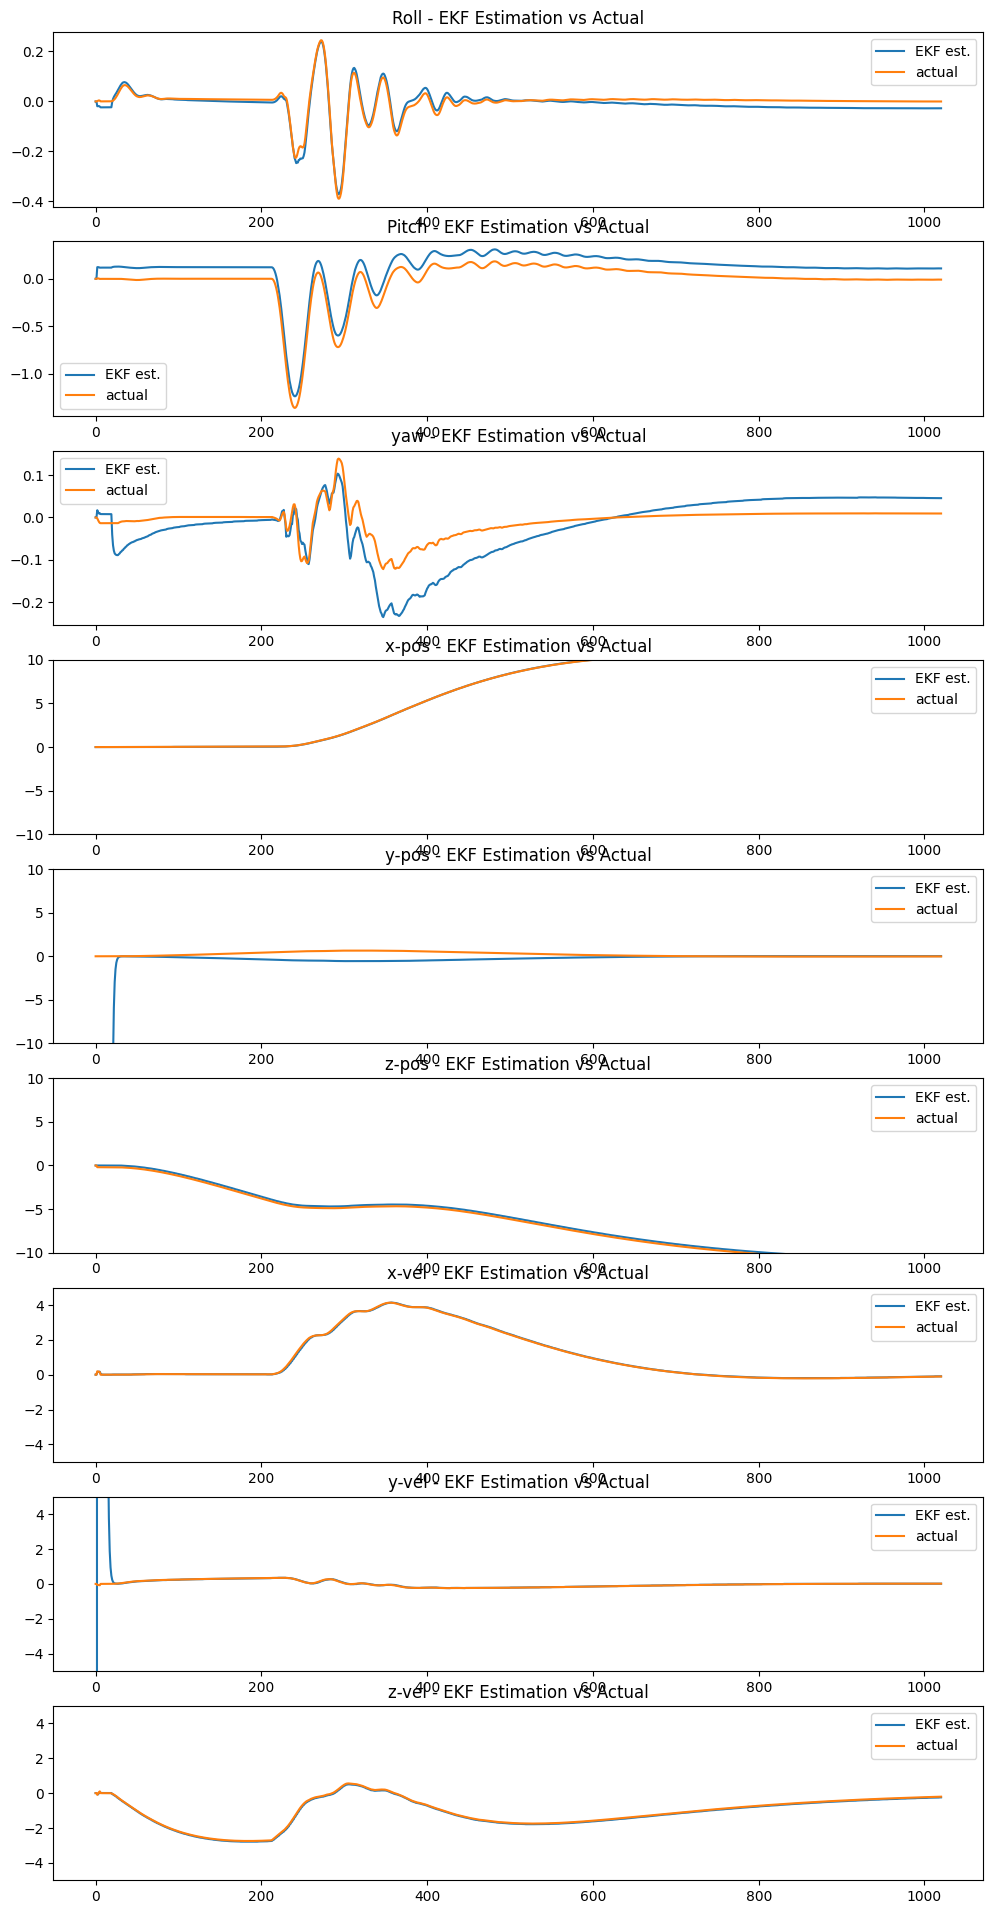

In [45]:

ekf_plot = {}

## Run full EKF estimation with provided variances for sensor estimation
for gvar in [0.01, 1, 10, 100]:
    ekf_vals = run_full_ekf({
        'avar': 1e2**2,
        #'gvar': 0.01**2,
        'gvar': gvar**2,
        'avar_norm': 1e2**2,
        'mvar': 0.01**2,
        'gps_pvar': 1,
        'gps_vvar': 1})

    ekf_plot[f'{gvar}'] = ekf_vals

fig, ax = plt.subplots(9,1, figsize=(12,24))

ax[0].plot(range(0,len(ekf_vals['ekf_roll'])), ekf_vals['ekf_roll'], label='EKF est.')
ax[0].plot(range(0,len(ctx['eul_x_a'])), ctx['eul_x_a'], label='actual')
ax[0].set_title("Roll - EKF Estimation vs Actual")
ax[0].legend()

ax[1].plot(range(0,len(ekf_vals['ekf_pitch'])), ekf_vals['ekf_pitch'], label='EKF est.')
ax[1].plot(range(0,len(ctx['eul_y_a'])), ctx['eul_y_a'], label='actual')
ax[1].set_title("Pitch - EKF Estimation vs Actual")
ax[1].legend()

ax[2].plot(range(0,len(ekf_vals['ekf_yaw'])), ekf_vals['ekf_yaw'], label='EKF est.')
ax[2].plot(range(0,len(ctx['eul_z_a'])), ctx['eul_z_a'], label='actual')
ax[2].set_title("yaw - EKF Estimation vs Actual")
ax[2].legend()

ax[3].plot(range(0,len(ekf_vals['ekf_pos_x'])), ekf_vals['ekf_pos_x'], label='EKF est.')
ax[3].plot(range(0,len(ctx['pos_x_a'])), ctx['pos_x_a'], label='actual')
ax[3].set_title("x-pos - EKF Estimation vs Actual")
ax[3].legend()

ax[4].plot(range(0,len(ekf_vals['ekf_pos_y'])), ekf_vals['ekf_pos_y'], label='EKF est.')
ax[4].plot(range(0,len(ctx['pos_y_a'])), ctx['pos_y_a'], label='actual')
ax[4].set_title("y-pos - EKF Estimation vs Actual")
ax[4].legend()

ax[5].plot(range(0,len(ekf_vals['ekf_pos_z'])), ekf_vals['ekf_pos_z'], label='EKF est.')
ax[5].plot(range(0,len(ctx['pos_z_a'])), ctx['pos_z_a'], label='actual')
ax[5].set_title("z-pos - EKF Estimation vs Actual")
ax[5].legend()

ax[6].plot(range(0,len(ekf_vals['ekf_vel_x'])), ekf_vals['ekf_vel_x'], label='EKF est.')
ax[6].plot(range(0,len(ctx['vel_x_a'])), ctx['vel_x_a'], label='actual')
ax[6].set_title("x-vel - EKF Estimation vs Actual")
ax[6].legend()

ax[7].plot(range(0,len(ekf_vals['ekf_vel_y'])), ekf_vals['ekf_vel_y'], label='EKF est.')
ax[7].plot(range(0,len(ctx['vel_y_a'])), ctx['vel_y_a'], label='actual')
ax[7].set_title("y-vel - EKF Estimation vs Actual")
ax[7].legend()

ax[8].plot(range(0,len(ekf_vals['ekf_vel_z'])), ekf_vals['ekf_vel_z'], label='EKF est.')
ax[8].plot(range(0,len(ctx['vel_z_a'])), ctx['vel_z_a'], label='actual')
ax[8].set_title("z-vel - EKF Estimation vs Actual")
ax[8].legend()

for en in [3,4,5]:
    ax[en].set_ylim(-10,10)
for en in [6,7,8]:
    ax[en].set_ylim(-5,5)
    
plt.show()

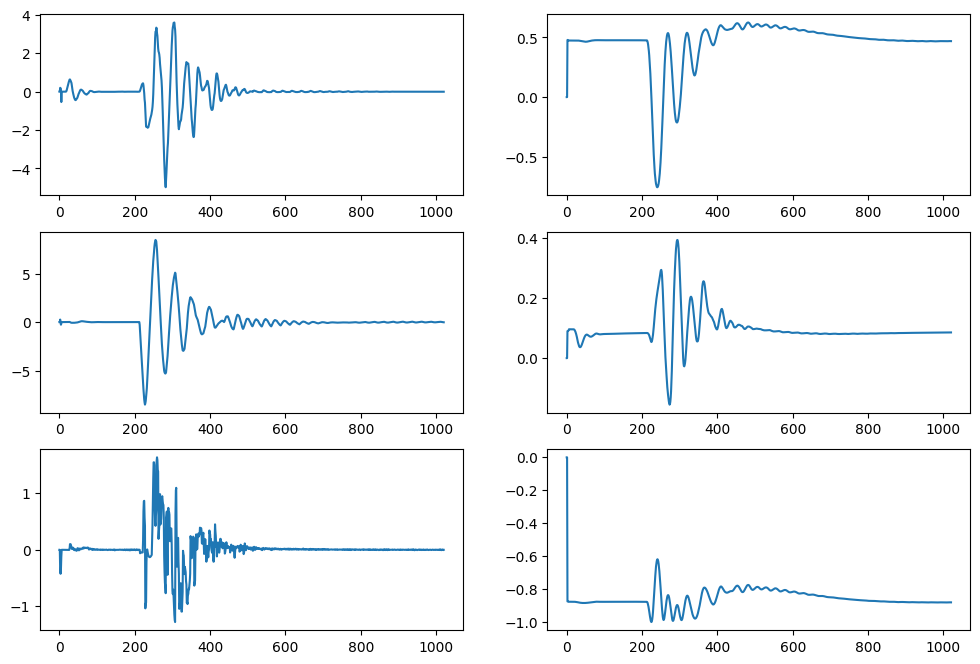

In [43]:
fig, ax = plt.subplots(3,2, figsize=(12,8))

dlen = len(ctx['gyro_x'])
ax[0, 0].plot(range(0,dlen), ctx['gyro_x'])
ax[1, 0].plot(range(0,dlen), ctx['gyro_y'])
ax[2, 0].plot(range(0,dlen), ctx['gyro_z'])

ax[0, 1].plot(range(0,dlen), ctx['comp_x'])
ax[1, 1].plot(range(0,dlen), ctx['comp_y'])
ax[2, 1].plot(range(0,dlen), ctx['comp_z'])

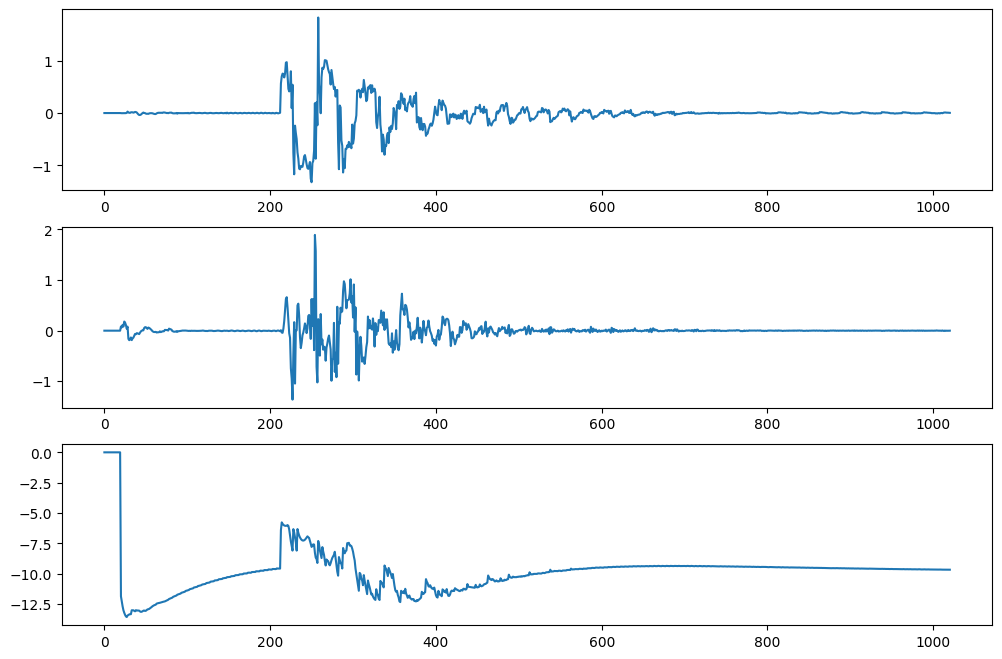

In [12]:

fig, ax = plt.subplots(3,1, figsize=(12,8))
ax[0].plot(range(0,dlen), ctx['accel_x'])
ax[1].plot(range(0,dlen), ctx['accel_y'])
ax[2].plot(range(0,dlen), ctx['accel_z'])


[ 1.         -3.18063855  3.86119435 -2.11215536  0.43826514]
[0.0004166 0.0016664 0.0024996 0.0016664 0.0004166]


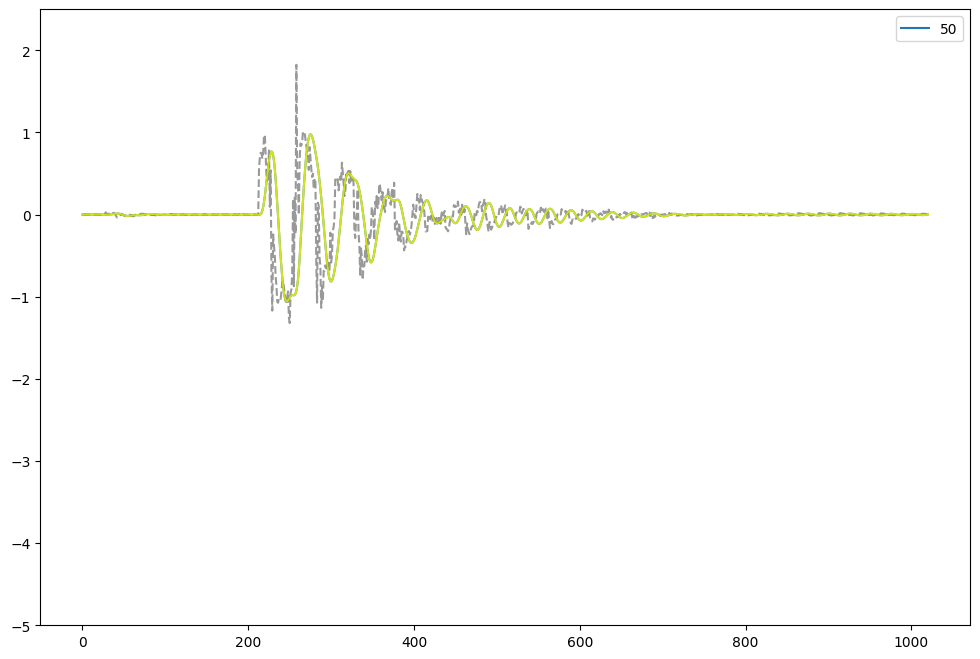

In [13]:

fs = 1000  # sampling frequency (Hz)
order = 4
cutoff = 50  # cutoff frequency (Hz)
fig, ax = plt.subplots(1,1, figsize=(12,8))
cutoff = 50
normal_cutoff = cutoff / (fs / 2)  # normalized cutoff
b, a = butter(order, normal_cutoff, btype='low', analog=False)

zf = lfilter_zi(b, a) * 0
new_acc_x = []
for i in range(0,len(ctx['accel_x'])):
    y, zf = lfilter(b,a, [ctx['accel_x'][i]], zi=zf)
    new_acc_x.append(y)
    
filtered_signal = lfilter(b, a, ctx['accel_x'])
ax.plot(range(0,len(filtered_signal)), filtered_signal, label=cutoff)    
ax.plot(range(0,len(filtered_signal)), ctx['accel_x'], color='black', linestyle='--', alpha=0.4)
ax.plot(range(0,len(new_acc_x)), new_acc_x, color='yellow', linestyle='-', alpha=0.8)

ax.legend()
ax.set_ylim(-5,2.5)

print(a)
print(b)
ax = np.array([ 1.0, -3.18063855, 3.86119435, -2.11215536, 0.43826514])
bx = np.array([0.0004166, 0.0016664, 0.0024996, 0.0016664, 0.0004166])


Text(0.5, 1.0, '$m_{z}$ Kalman error')

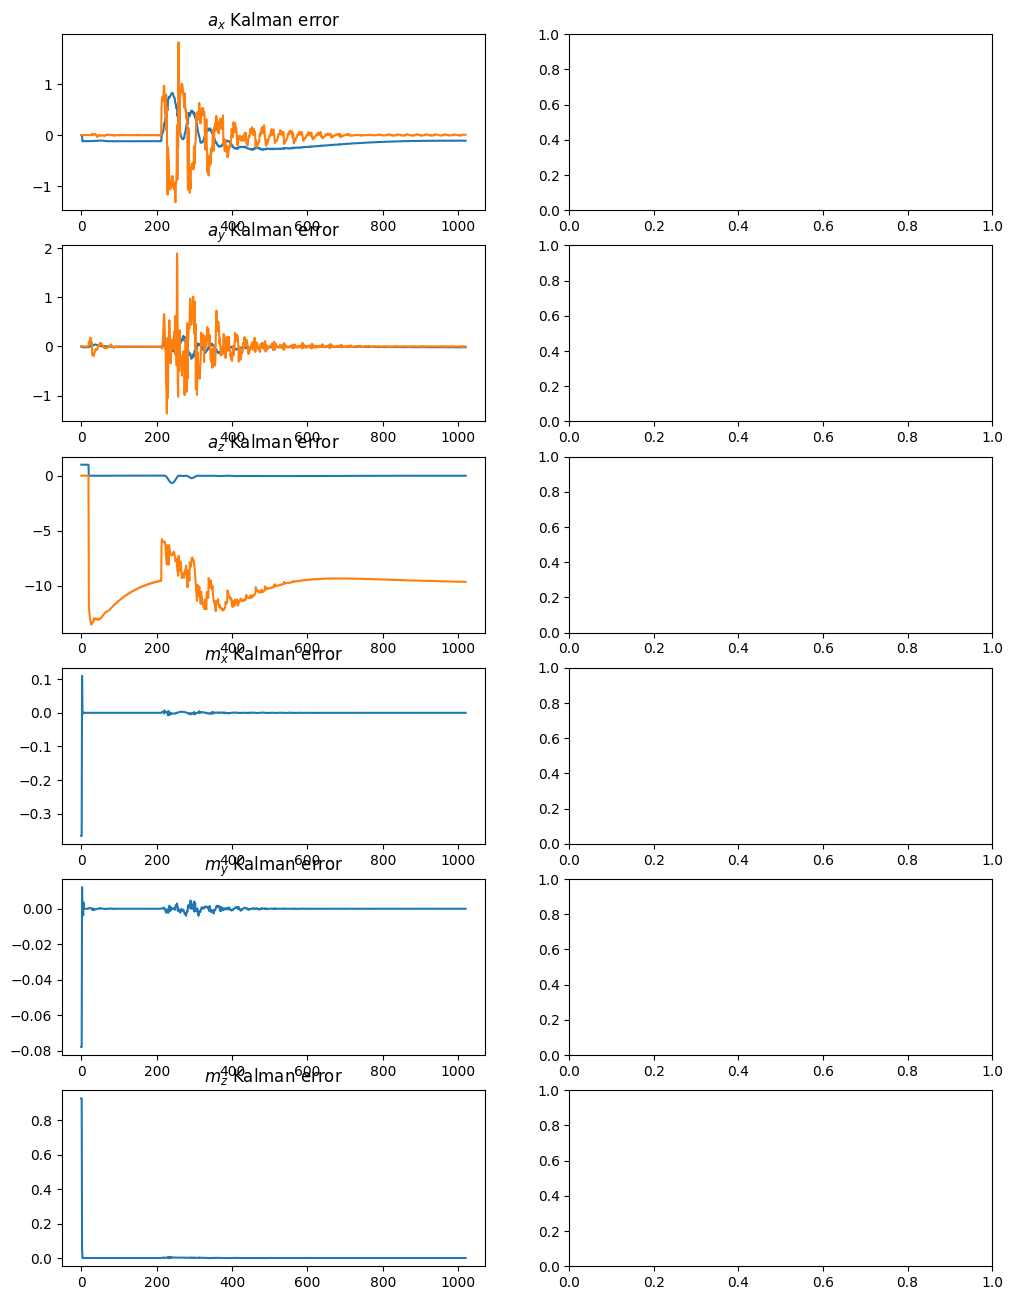

In [24]:
fig, ax = plt.subplots(6,2,figsize=(12,16))
ax[0,0].plot(range(0,len(vt_plot)), [vt_plot[i][0][0] for i in range(0,len(vt_plot))])
ax[0,0].set_title(r"$a_{x}$ Kalman error")
ax[0,0].plot(range(0,len(ctx['accel_x'])), ctx['accel_x'])

# Add plots of kalman gain for a reading (of the 12-readings, i.e. x-accel) to all of the 10-state vectors
#ax[0,1].plot(

ax[1,0].plot(range(0,len(vt_plot)), [vt_plot[i][1][0] for i in range(0,len(vt_plot))])
ax[1,0].set_title(r"$a_{y}$ Kalman error")
ax[1,0].plot(range(0,len(ctx['accel_y'])), ctx['accel_y'])

ax[2,0].plot(range(0,len(vt_plot)), [vt_plot[i][2][0] for i in range(0,len(vt_plot))])
ax[2,0].set_title(r"$a_{z}$ Kalman error")
ax[2,0].plot(range(0,len(ctx['accel_z'])), ctx['accel_z'])

ax[3,0].plot(range(0,len(vt_plot)), [vt_plot[i][3][0] for i in range(0,len(vt_plot))])
ax[3,0].set_title(r"$m_{x}$ Kalman error")
ax[4,0].plot(range(0,len(vt_plot)), [vt_plot[i][4][0] for i in range(0,len(vt_plot))])
ax[4,0].set_title(r"$m_{y}$ Kalman error")
ax[5,0].plot(range(0,len(vt_plot)), [vt_plot[i][5][0] for i in range(0,len(vt_plot))])
ax[5,0].set_title(r"$m_{z}$ Kalman error")
